## Preliminaries

In [ ]:
%%bash

rm -rf *.sh

<br>

### Packages & Libraries

**Packages**

In [ ]:
import subprocess

In [ ]:
if 'google.colab' in str(get_ipython()):
    subprocess.run('wget -q https://raw.githubusercontent.com/exhypotheses/beans/develop/scripts.sh', shell=True)
    subprocess.run('chmod u+x scripts.sh', shell=True)
    subprocess.run('./scripts.sh', shell=True)

<br>

**Libraries**

* `pd.options.display.max_info_columns = 9`

In [ ]:
import collections
import os

import logging

import numpy as np
import pandas as pd

import theano
import pymc3
import graphviz
import arviz as az

import secrets
import hashlib
import json

<br>

### Logging

In [ ]:
logging.basicConfig(level=logging.WARNING, format='%(message)s\n%(asctime)s.%(msecs)03d', datefmt='%Y-%m-%d %H:%M:%S')
logger = logging.getLogger(__name__)

<br>

### Custom

In [ ]:
import beans.graphics.relational
import beans.graphics.settings

import beans.src.modelling
import beans.src.set

import beans.functions.encode
import beans.functions.knee
import beans.functions.project
import beans.functions.sample
import beans.functions.scale

import beans.models.neural


<br>

Graphs

In [ ]:
relational = beans.graphics.relational.Relational()

RelationalGraphLabels = collections.namedtuple(typename='RelationalGraphLabels',
                                               field_names=['title', 'xlabel', 'ylabel'])

<br>

Settings

In [ ]:
settings = beans.graphics.settings.Settings()

settings.layout()
settings.aesthetics()

<br>

Paths

In [ ]:
warehouse = 'warehouse'

if not os.path.exists(warehouse):
    os.makedirs(warehouse)

<br>

Random States

In [ ]:
SEED = 5
np.random.seed(seed=SEED)

<br>
<br>

## Data

Formulae & Inspection Options

**If** $\small{L}$: major axis length, $\small{l}$: minor axis length, $\small{A}$: area, $\small{P}$: perimeter, and $\small{E_d}$: equivalent diameter, **then**

term | the formula of the term
:--- | :---
aspect ratio | $\frac{L}{\mathcal{l}}$
eccentricity | $\sqrt{(1 - \frac{l^2}{L^2})}$
roundness | $ \frac{4 \pi A}{P^2}$
compactness | $\frac{E_d}{L}$





### Read

In [ ]:
data = beans.src.set.Set()

In [ ]:
training_split = data.training()
logger.warning('Training {}'.format(training_split.shape))

target = data.target
labels = data.labels
logger.warning('\nThe target field is: {}'.format(target))
logger.warning("\nThe target field's labels: {}".format(labels))

<br>

### Preprocess

<br>

**Sample**

In [ ]:
# Notes

<br>

**Scale**

* Add the scaler object to the preprocessing pickle

In [ ]:
# Notes

<br>

**Encode the Dependent Variables**

In [ ]:
# Notes

<br>

**Structure**

In [ ]:
# Notes

<br>
<br>

## Modelling

### Construct Underlying Type

Reference

* https://docs.pymc.io/api/inference.html#module-pymc3.sampling

In [ ]:
neural = beans.models.neural.Neural()

In [ ]:
neural_network = neural.exc(input=x_training_points, output=y_training_points)

<br>

### DAG

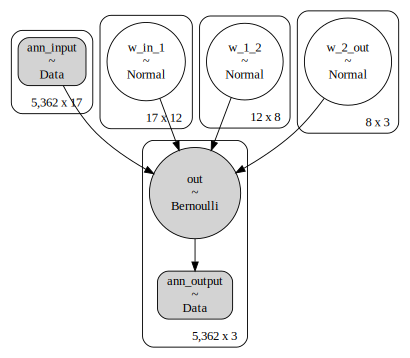

In [ ]:
# The DAG
diagram = pymc3.model_graph.ModelGraph(model=neural_network).make_graph()
diagram.node_attr.update(shape='circle')
diagram.graph_attr.update(size="5.7,7.9")

# Diagrams
diagram.save(os.path.join(warehouse, 'model.gv'))
graphviz.render(engine='dot', format='pdf', filepath=os.path.join(warehouse, 'model.gv'))

graphviz.Source.from_file(filename=os.path.join(warehouse, 'model.gv'))

<br>

### Inference

In [ ]:
pymc3.theanof.set_tt_rng(pymc3.theanof.RandomStream(seed=SEED))

<br>

Inference

* [class pymc3.variational.inference.ADVI(*args, **kwargs)](https://docs.pymc.io/api/inference.html#module-pymc3.variational.inference)


In [ ]:
%%time
with neural_network:

    # Either
    inference = pymc3.FullRankADVI()
    approximation = pymc3.fit(n=60000, method=inference)


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
2021-05-31 15:23:50.152


Finished [100%]: Average Loss = 699.92
Finished [100%]: Average Loss = 699.92
2021-05-31 15:37:24.034


CPU times: user 14min 49s, sys: 10min 50s, total: 25min 40s
Wall time: 13min 58s


<br>

Evidence Lower Bound

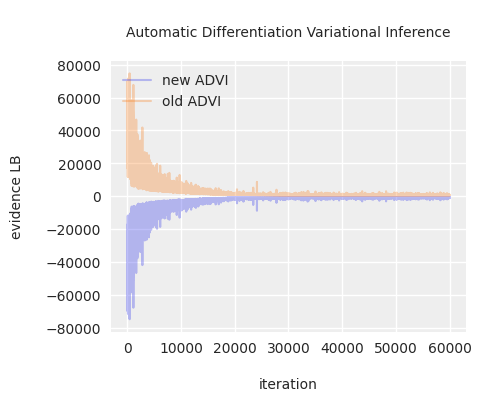

In [ ]:
ax = relational.figure(width=4.7, height=3.9)
ax.plot(-inference.hist, label='new ADVI', alpha=0.3)
ax.plot(approximation.hist, label='old ADVI', alpha=0.3)

relational.annotation(handle=ax, 
                      labels=RelationalGraphLabels._make(['\nAutomatic Differentiation Variational Inference\n', 
                                                          '\niteration', 'evidence LB\n']))

ax.legend(loc='upper left', fontsize='small');

<br>

### Trace

In [ ]:
trace = approximation.sample(draws=2000)

logger.warning('\n{}'.format(trace.varnames))
logger.warning('\n{}'.format(trace.get_sampler_stats))


['w_in_1', 'w_1_2', 'w_2_out']
2021-05-31 15:55:00.871

<bound method MultiTrace.get_sampler_stats of <MultiTrace: 1 chains, 2000 iterations, 3 variables>>
2021-05-31 15:55:00.874


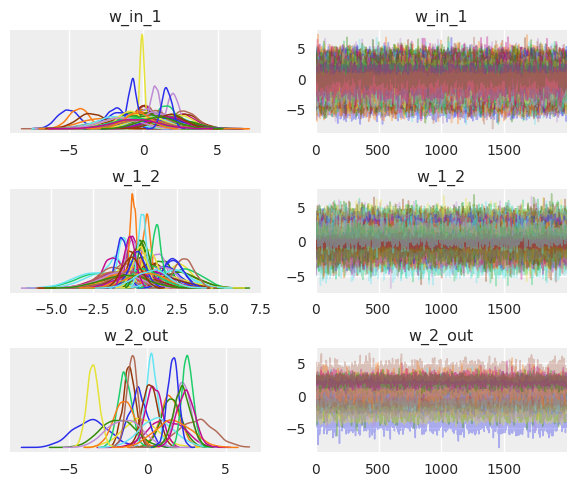

In [ ]:
with neural_network:
    pymc3.plot_trace(data=trace, figsize=(5.65, 4.75))

<br>
<br>

## Persist

### Preliminaries

Model specific salt; also model-run specific.

In [ ]:
salt = os.urandom(64)

Accompanying 

In [ ]:
kappa = secrets.token_bytes(nbytes=64)

Hence

In [ ]:
key = hashlib.pbkdf2_hmac('sha384', kappa, salt, 200000, dklen=128)

In [ ]:
with open(os.path.join(warehouse, 'kappa.txt'), 'w') as f:
    f.write('salt, {}'.format(salt))
    f.write('\r\nkey, {}'.format(key))
f.close()

<br>

### Model

Neural Network

In [ ]:
{}

<br>

Trace

In [ ]:
pymc3.backends.ndarray.save_trace(trace=trace, directory=os.path.join(os.getcwd(), 'trace'), overwrite=True)

In [ ]:
%%bash

rm -rf trace.zip
zip -r trace trace